# **Detect Faces Using Trained Weights**

Use the face detector trained by coco weight to detect faces from image.

### Import, Setup Configuration, and Load Model

In [19]:
# Import necessary modules
import os
import face_detection
import numpy as np
import skimage.io
from mrcnn import model as modellib
from mrcnn import visualize

# Define model directory and weights path
MODEL_DIR = os.path.abspath('D:/Hanifan/Face-Detection-MaskRCNN/logs')
WEIGHTS_PATH = os.path.abspath('D:/Hanifan/Face-Detection-MaskRCNN/logs/mask_rcnn_face_new.h5')

# Load configuration
class InferenceConfig(face_detection.DatasetConfig):
    # Set batch size to 1 for inference
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # Percobaan perubahan hyperparameter
    # RPN_NMS_THRESHOLD = 0.8 
    DETECTION_MIN_CONFIDENCE = 0.8
    # DETECTION_NMS_THRESHOLD = 0.5
    # RPN_ANCHOR_STRIDE = 2

config = InferenceConfig()

# Load and resize image
image_path = os.path.abspath('D:/Hanifan/blur-5.jpg')
image = skimage.io.imread(image_path)

# Initialize the model in inference mode
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load pre-trained weights
model.load_weights(WEIGHTS_PATH, by_name=True)


### Detection Process

Processing 1 images
image                    shape: (934, 1400, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1400.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Detection Results:
ROIs: [[244 645 513 851]]
Class IDs: [1]
Scores: [0.975322]
Masks shape: (934, 1400, 1)
Detections found.


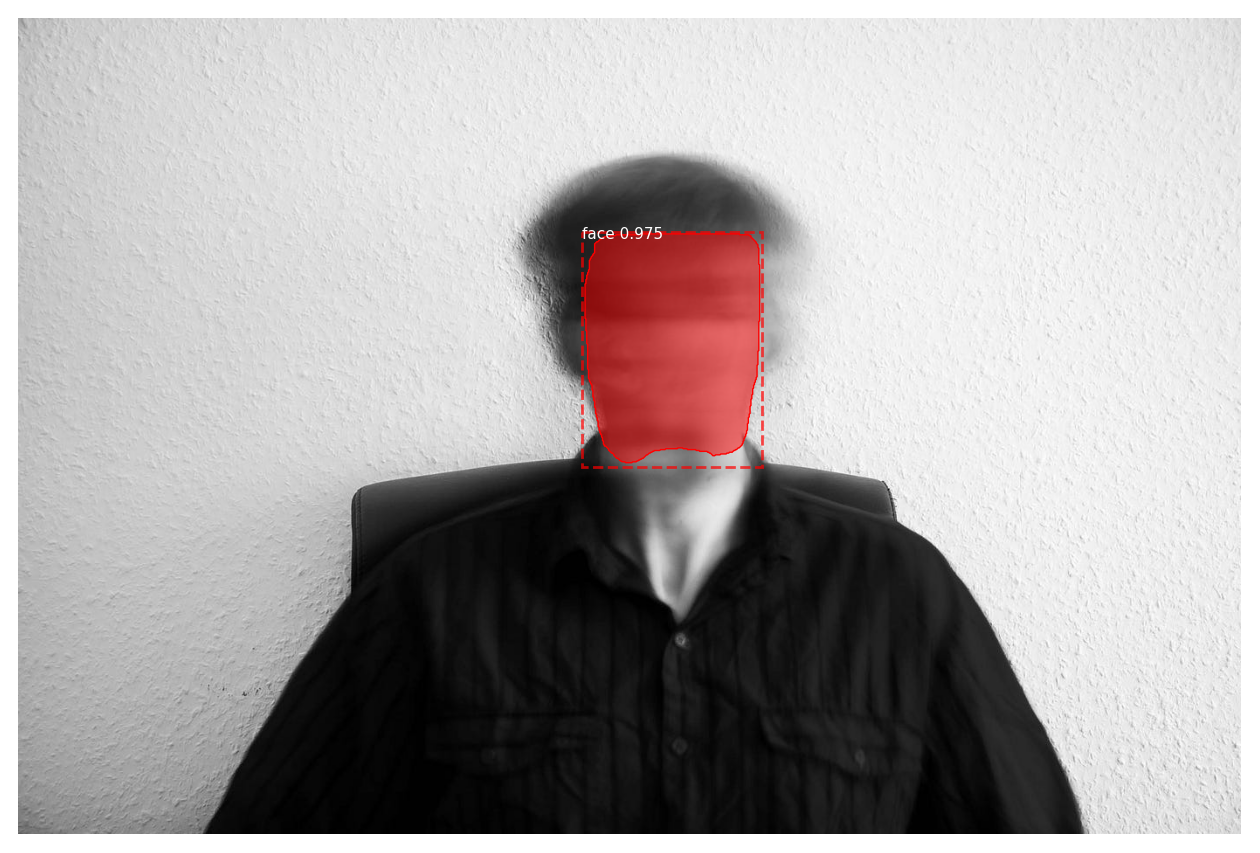

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 2)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 1000, 2, 4)       min:   -4.13781  max:    3.29160  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.14417  max:    0.99521  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32
1 detections: ['face']


In [20]:
# Run detection
results = model.detect([image], verbose=1)
r = results[0]

# Debug: Print detection results
print("Detection Results:")
print("ROIs:", r['rois'])
print("Class IDs:", r['class_ids'])
print("Scores:", r['scores'])
print("Masks shape:", r['masks'].shape if r['masks'] is not None else "None")

# Refine bounding boxes
def refine_bounding_boxes(rois, scores, threshold=0.7):
    refined_boxes = []
    for roi, score in zip(rois, scores):
        if score >= threshold:
            refined_boxes.append(roi)
    return np.array(refined_boxes)

r['rois'] = refine_bounding_boxes(r['rois'], r['scores'], threshold=config.DETECTION_MIN_CONFIDENCE)

# Check detection results
if len(r['rois']) == 0:
    print("No detections found.")
else:
    print("Detections found.")
    # Visualize the results
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                                ['background', 'face'], r['scores'])

    # Additional model analysis (only if detections are found)
    mrcnn = model.run_graph([image], [
        ("proposals", model.keras_model.get_layer("ROI").output),
        ("probs", model.keras_model.get_layer("mrcnn_class").output),
        ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
        ("masks", model.keras_model.get_layer("mrcnn_mask").output),
        ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ])

    det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
    if det_class_ids.size > 0:
        det_count = np.where(det_class_ids == 0)[0][0] if np.where(det_class_ids == 0)[0].size > 0 else det_class_ids.size
        det_class_ids = det_class_ids[:det_count]
        detections = mrcnn['detections'][0, :det_count]

        print("{} detections: {}".format(
            det_count, np.array(['background', 'face'])[det_class_ids]))
    else:
        print("No detections found in mrcnn run_graph output.")